![msg](msg.jpg)

In [25]:
#Imports 
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 

from tqdm import tqdm

from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS  
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.viscous_evolution import ViscousEvolutionFV
from DiscEvolution.driver import PlanetDiscDriver
from DiscEvolution.io import Event_Controller

In [26]:
# Physical parameters
#Assumed
Mstar = 1.0 * u.solMass #Default 1 solmass 
Rstar = 1.0 * u.solRad #Default 1 solRad
mu = 2.33  # Mean molecular weight, assumed

#Given
M_disk_0 = 0.05 * u.solMass  #Initial Disk Mass, default is 0.05 solmass
gamma = 1.0
Rc = 1.0 * u.AU #Default 1AU
#Mdot_0 = 
t_final = 1 * u.Myr 

# LBP surface density profile with gamma = 1: Sigma(r) = (M_disk / (2*pi*Rc*r)) * exp(-r/Rc)
def Sigma_LBP_1(r) -> float:
    val = (M_disk_0)/(2* np.pi * Rc * r) * np.exp((-1*r)/(Rc))
    if (val.cgs.unit != (u.g / (u.cm)**2)):
        print("Sigma_1 error")
        return 0
    return val.cgs

def Temperature(r) -> float:
    T_0 = 150 * u.K 
    val  = T_0 * (r / (1.0 * u.AU))**(-1/2)
    if val.cgs.unit != u.K:
        print('Temperature error')
        return 0
    return val.cgs

#Taken from A2
def Omega(r) -> float:
    val = np.sqrt((const.G*Mstar)/(r**3))
    if (val.cgs.unit != (1 / u.s)): 
        print("Omega error")
        return 0
    return val.cgs

#Taken from A2
def c_s(r) -> float:
    val = np.sqrt((const.k_B*Temperature(r))/(mu*const.m_p))
    if (val.cgs.unit != (u.cm / u.s)): 
        print("c_s error")
        return 0
    return val.cgs

def H(r) -> float: 
    val = c_s(r)/Omega(r)
    if val.cgs.unit != (u.cm):
        print("H error")
        return 0
    return val.cgs

In [27]:
#Given Mdisk, Mdot(0), Rc -> Calculate alpha and Sigma0
M_disk_0 = 0.05 * u.solMass
Mdot_0 = 1E-7 * u.solMass / u.yr  #Armitage p.21
Rc = 1.0 * u.AU

#Armitage eq 74
#nu*Sigma = Mdot/(3pi) * (1 - sqrt(r_star/r))
##alpha * c_s * H * Sigma = (Mdot / 3*pi) * (1 - sqrt(r_star/r))
###alpha = (Mdot / 3*pi) / (c_s * H * Sigma) * (1 - sqrt(r_star/r))

def alpha(r) -> float:
    # Convert all inputs to CGS values (no units)
    Mdot_cgs = Mdot_0.to(u.g / u.s).value  # g/s
    cs_val = c_s(r).value                   # cm/s
    H_val = H(r).value                      # cm
    Sigma_val = Sigma_LBP_1(r).value       # g/cm²
    Rstar_val = Rstar.to(u.cm).value       # cm
    r_val = r.to(u.cm).value               # cm
    
    # Calculate dimensionless alpha
    alpha = (Mdot_cgs / (3*np.pi)) * (1/(cs_val * H_val * Sigma_val)) * (1 - np.sqrt(Rstar_val/r_val))
    
    return alpha  # Pure float, dimensionless

r_ref = Rc #Not Rstar
alpha_val = alpha(r_ref)

Sigma_0 = Sigma_LBP_1(r_ref)

print(f"Accretion rate: {Mdot_0:.3e}")
print(f"At radius: {r_ref.to(u.AU):.3f}")
print(f"\nCalculated alpha: {alpha_val:.3e}")
print(f"Sigma_0: {Sigma_0.cgs:.3e}")


Accretion rate: 1.000e-07 solMass / yr
At radius: 1.000 AU

Calculated alpha: 8.973e-04
Sigma_0: 2.601e+04 g / cm2


In [ ]:
# 1) Create grid
#R_in = Rstar.to('AU').value  # AU
R_in = 0.1 #AU
R_out = 100.0  # AU
Ncells = 100

grid = Grid(R_in, R_out, Ncells, spacing='log')

# 2) Create star
star = SimpleStar(M=1.0)  # Already in solar masses and radii

In [29]:
#1. turbulence dominated disk with IrradiatedEOS (Zhu2012 opacity)

# 3) Create IrradiatedEOS - computes T self-consistently from irradiation + viscous heating
# No h0 or q needed - temperature is computed from physics
eos = IrradiatedEOS(
    star,
    alpha_t=alpha_val,    # Turbulent alpha
    Tc=10,                # External/nebular temperature floor (K)
    Tmax=1500,            # Maximum temperature cap (K)
    mu=mu,
    gamma=1.0,
    accrete=True          # Include viscous heating from accretion
)
eos.set_grid(grid)

# 4) Create surface density array from LBP profile
R_centers = grid.Rc  # AU
Sigma_initial = np.array([Sigma_LBP_1(r * u.AU).value for r in R_centers])

# 5) Create the disc
disc = AccretionDisc(grid, star, eos, Sigma=Sigma_initial)
disc._planetesimal = False

# 6) Update EOS to compute temperature from initial Sigma
# amax = max grain size for opacity calculation
eos.update(0, disc.Sigma, amax=1e-4)

# Verify the setup
print(f"\nDisc setup:")
print(f"  Grid: {disc.Ncells} cells from {R_in} to {R_out} AU")
print(f"  Disc mass: {disc.Mtot()/const.M_sun.to(u.g).value:.3e} solar masses")
print(f"  Alpha: {alpha_val:.3e}")

# Check profiles at key radii
print(f"\nTemperature profile (IrradiatedEOS + Zhu2012 opacity):")
for r_check in [0.5, 1.0, 5.0, 10.0, 30.0]:
    idx = np.argmin(np.abs(disc.R - r_check))
    print(f"  R = {disc.R[idx]:5.1f} AU: T = {disc.T[idx]:6.1f} K, nu = {disc.nu[idx]:.2e}")


Disc setup:
  Grid: 200 cells from 0.1 to 100.0 AU
  Disc mass: 4.525e-02 solar masses
  Alpha: 8.973e-04

Temperature profile (IrradiatedEOS + Zhu2012 opacity):
  R =   0.5 AU: T = 1500.0 K, nu = 1.90e-06
  R =   1.0 AU: T = 1500.0 K, nu = 5.37e-06
  R =   5.0 AU: T =   48.0 K, nu = 1.96e-06
  R =  10.1 AU: T =   33.7 K, nu = 3.88e-06
  R =  30.4 AU: T =   21.1 K, nu = 1.28e-05


In [30]:
# Evolution with correct time units
# DiscEvolution uses code units: 1 year = 2π code time units

from DiscEvolution.constants import yr as yr_code  # yr_code = 2π

# Set up evolution
visc_evol = ViscousEvolutionFV(tol=0.5, boundary='power_law', in_bound='Mdot')
driver = PlanetDiscDriver(disc, gas=visc_evol, t0=0.0)

# Time in code units
t_final_yr = t_final.to(u.yr).value  # 1e6 years
t_final_code = t_final_yr * yr_code  # Convert to code units

# Check timestep
dt_max = visc_evol.max_timestep(disc)
dt_max_yr = dt_max / yr_code
print(f"=== EVOLUTION SETUP ===")
print(f"t_final: {t_final_yr:.0e} years = {t_final_code:.2e} code units")
print(f"dt_max: {dt_max:.2e} code units = {dt_max_yr:.1f} years")
print(f"Estimated steps: {t_final_code/dt_max:.1e}")

# Output times (in code units)
output_times_yr = np.linspace(0, t_final_yr, 11)  # Every 100 kyr
output_times_code = output_times_yr * yr_code
io = Event_Controller(save=output_times_code)

history = {'t_yr': [], 'Mtot': [], 'Rout': [], 'dt_yr': []}

print(f"\nStarting evolution...")
pbar = tqdm(total=t_final_yr, unit='yr', desc='Evolution')
last_t_yr = 0.0
step_count = 0

while not io.finished():
    ti = io.next_event_time()
    
    while driver.t < ti:
        dt = driver(ti)
        step_count += 1
        
        # Update progress
        t_yr = driver.t / yr_code
        pbar.update(t_yr - last_t_yr)
        last_t_yr = t_yr
        
        # Diagnostic every 1000 steps
        if step_count % 2000 == 0:
            dt_yr = dt / yr_code
            #print(f"\nStep {step_count}: t = {t_yr:.2e} yr, dt = {dt_yr:.1f} yr")
    
    # Store at output times
    if io.check_event(driver.t, 'save'):
        dt_current = visc_evol.max_timestep(disc)
        history['t_yr'].append(driver.t / yr_code)
        history['Mtot'].append(disc.Mtot() * u.g.to(u.solMass))
        history['Rout'].append(disc.Rout())
        history['dt_yr'].append(dt_current / yr_code)
        io.pop_events(driver.t, 'save')

pbar.close()

print(f"\n=== EVOLUTION COMPLETE ===")
print(f"Total steps: {step_count}")
print(f"Final time: {driver.t/yr_code:.1e} years")
print(f"Final mass: {history['Mtot'][-1]:.3e} M_sun ({100*history['Mtot'][-1]/history['Mtot'][0]:.1f}% of initial)")
print(f"Average dt: {np.mean(history['dt_yr']):.1f} years")

=== EVOLUTION SETUP ===
t_final: 1e+06 years = 6.28e+06 code units
dt_max: 5.86e+00 code units = 0.9 years
Estimated steps: 1.1e+06

Starting evolution...


Evolution: 100%|██████████| 1000000.0/1000000.0 [21:59<00:00, 757.67yr/s]          


=== EVOLUTION COMPLETE ===
Total steps: 1072740
Final time: 1.0e+06 years
Final mass: 1.203e-02 M_sun (26.6% of initial)
Average dt: 0.9 years


<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/var/folders/gs/62b6262j1kx0f9d88dw3sf9c0000gn/T/ipykernel_34754/1003446731.py:8: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Disc Mass [M$_\odot$]')


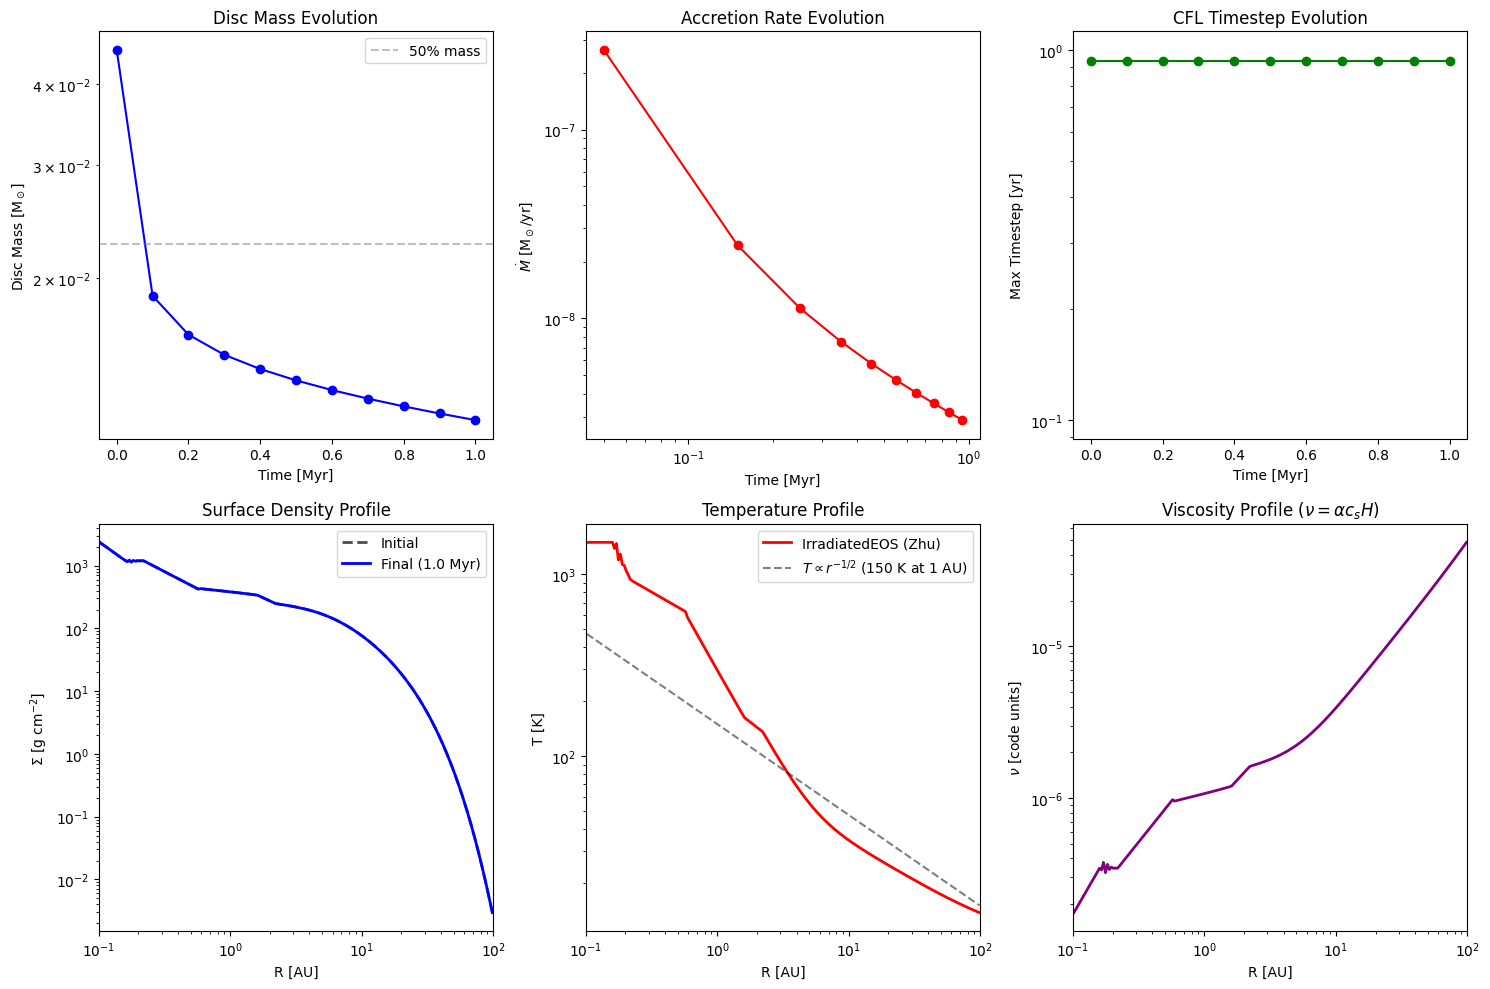


=== Summary ===
Initial mass: 4.525e-02 M_sun
Final mass:   1.203e-02 M_sun (26.6% remaining)
Mass lost:    3.323e-02 M_sun


In [31]:
# Standard disc evolution plots (based on example scripts)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Mass evolution over time
ax = axes[0, 0]
ax.semilogy(np.array(history['t_yr'])/1e6, np.array(history['Mtot']), 'o-', color='blue')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Disc Mass [M$_\odot$]')
ax.set_title('Disc Mass Evolution')
ax.axhline(history['Mtot'][0]*0.5, ls='--', color='gray', alpha=0.5, label='50% mass')
ax.legend()

# 2. Accretion rate (Mdot) evolution  
ax = axes[0, 1]
# Estimate Mdot from mass change
t_arr = np.array(history['t_yr'])
M_arr = np.array(history['Mtot'])
if len(t_arr) > 1:
    Mdot_est = -np.diff(M_arr) / np.diff(t_arr)  # M_sun/yr
    t_mid = 0.5*(t_arr[:-1] + t_arr[1:])
    ax.loglog(t_mid/1e6, Mdot_est, 'o-', color='red')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$\dot{M}$ [M$_\odot$/yr]')
ax.set_title('Accretion Rate Evolution')

# 3. Timestep evolution
ax = axes[0, 2]
ax.semilogy(np.array(history['t_yr'])/1e6, history['dt_yr'], 'o-', color='green')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Max Timestep [yr]')
ax.set_title('CFL Timestep Evolution')

# 4. Surface density profiles (initial vs final)
ax = axes[1, 0]
ax.loglog(disc.R, Sigma_initial, 'k--', label='Initial', alpha=0.7, lw=2)
ax.loglog(disc.R, disc.Sigma, 'b-', label=f'Final ({t_final_yr/1e6:.1f} Myr)', lw=2)
ax.set_xlabel('R [AU]')
ax.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
ax.set_title('Surface Density Profile')
ax.legend()
ax.set_xlim(R_in, R_out)

# 5. Temperature profile (computed by IrradiatedEOS)
ax = axes[1, 1]
ax.loglog(disc.R, disc.T, 'r-', lw=2, label='IrradiatedEOS (Zhu)')
# Compare to power-law T ∝ r^(-1/2)
T_powerlaw = 150 * (disc.R)**(-0.5)
ax.loglog(disc.R, T_powerlaw, 'k--', alpha=0.5, label=r'$T \propto r^{-1/2}$ (150 K at 1 AU)')
ax.set_xlabel('R [AU]')
ax.set_ylabel('T [K]')
ax.set_title('Temperature Profile')
ax.legend()
ax.set_xlim(R_in, R_out)

# 6. Viscosity profile (ν = α cs H)
ax = axes[1, 2]
ax.loglog(disc.R, disc.nu, 'purple', lw=2)
ax.set_xlabel('R [AU]')
ax.set_ylabel(r'$\nu$ [code units]')
ax.set_title(r'Viscosity Profile ($\nu = \alpha c_s H$)')
ax.set_xlim(R_in, R_out)

plt.tight_layout()
plt.savefig('Jan2026-Zhu_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n=== Summary ===")
print(f"Initial mass: {history['Mtot'][0]:.3e} M_sun")
print(f"Final mass:   {history['Mtot'][-1]:.3e} M_sun ({100*history['Mtot'][-1]/history['Mtot'][0]:.1f}% remaining)")
print(f"Mass lost:    {history['Mtot'][0] - history['Mtot'][-1]:.3e} M_sun")